### Install necessary packages

In [2]:
%pip install numpy
%pip install GPy
%pip install scipy
%pip install keras
%pip install matplotlib
%pip install pandas
%pip install scikit-learn
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Import libraries


In [ ]:
import numpy as np
import scipy.stats as stats
##Library neural nets
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
# Library for Gaussian process
import GPy
##Library for visualization
import matplotlib as mpl
mpl.style.use("seaborn-v0_8")
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib; matplotlib.rcParams['figure.figsize'] = (8,6)
from sklearn.preprocessing import MinMaxScaler
import pylab

### Split into input (X) and output (Y) variables

In [4]:
N = 1000 ##Sample Size
P = 1 ##Covariates
M = 10 ##replicates
X = np.array([np.ones(N)]).T ##Design matrix
kernel = GPy.kern.Exponential(1,1,0.1) ##Covariance Function
noise_var = 0.01 ##Nugget variance
# 1000 points evenly spaced over [0,1]
s = np.linspace(0,1,N).reshape(-1,1)
mu = np.ones(N).reshape(-1,1) # vector of the means
nugget = np.eye(N) * noise_var ##Nugget matrix
cov_mat = kernel.K(s) + nugget ##Covariance matrix
# Generate M sample path with mean mu and covariance C
np.random.seed(1)
y = np.random.multivariate_normal(mu[:,0],cov_mat,M).T

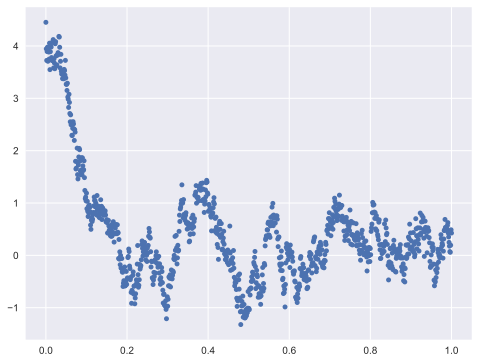

<Figure size 800x600 with 0 Axes>

In [5]:
plt.plot(s,y[:,0],".",mew=1.5)
plt.show()
plt.savefig("trueGP.pdf")

### Create a neural network with three hidden layers (as mentioned in S2)


In [129]:
def create_mlp_3(feature_dim):
    # create model
    model = Sequential()
    
    # Hidden layers
    model.add(Dense(100, input_dim=feature_dim, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model

def create_mlp_7(feature_dim):
   # create model
    model = Sequential()
    
    # Hidden layers
    model.add(Dense(100, input_dim = feature_dim,  kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model### Create a neural network with 7 hidden layers

def create_mlp_6w(feature_dim):
   # create model
    model = Sequential()
    
    # Hidden layers
    model.add(Dense(400, input_dim = feature_dim,  kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model### Create a neural network with 7 hidden layers

### Generate Basis Functions

In [ ]:
# 1 Dimensional basis functions
num_basis_1D = [10,19,37,73]
knots_1D = [np.linspace(0,1,i) for i in num_basis_1D]
K_1D = np.sum(num_basis_1D) ## basis size
## Wendland kernel
K_1DW = 0 ## basis size
phi_1DW = np.zeros((N, sum(num_basis_1D)))
for res in range(len(num_basis_1D)):
    theta = 1/num_basis_1D[res]*2.5
    for i in range(num_basis_1D[res]):
        d = np.absolute(s-knots_1D[res][i])/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_1DW[j,i + K_1DW] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi_1DW[j,i + K_1DW] = 0
    K_1DW = K_1DW + num_basis_1D[res]
    
## Gaussian kernel
K_1DG = 0 ## basis size
phi_1DG = np.zeros((N, sum(num_basis_1D)))
for res in range(len(num_basis_1D)):
    theta = 1/num_basis_1D[res]
    for i in range(num_basis_1D[res]):
        d = np.absolute(s-knots_1D[res][i])/theta
        for j in range(len(d)):
            phi_1DG[j,i + K_1DG] = np.exp(-d[j]**2)
    K_1DG = K_1DG + num_basis_1D[res]
    
## triangular kernel
K_1DT = 0 ## basis size
phi_1DT = np.zeros((N, sum(num_basis_1D)))
for res in range(len(num_basis_1D)):
    theta = 1/num_basis_1D[res]*1.5
    for i in range(num_basis_1D[res]):
        d = np.absolute(s-knots_1D[res][i])/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_1DT[j,i + K_1DT] = 1-d[j]
            else:
                phi_1DT[j,i + K_1DT] = 0
    K_1DT = K_1DT + num_basis_1D[res]


In [8]:
print(np.mean(phi_1DW[:,0]), np.mean(phi_1DG[:,0]), np.mean(phi_1DT[:,0]))

0.07450000000000061 0.08903406985273053 0.07542542542542545


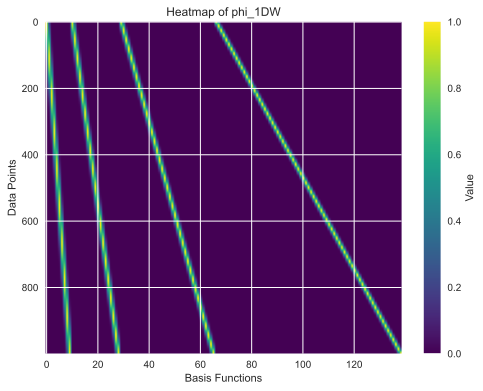

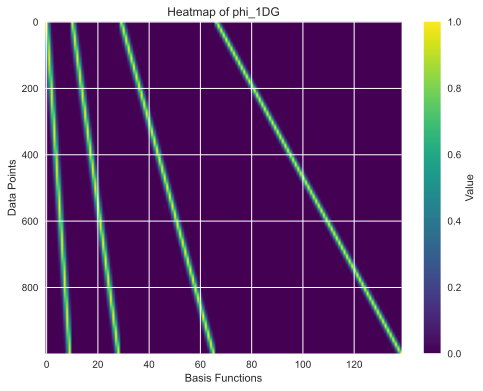

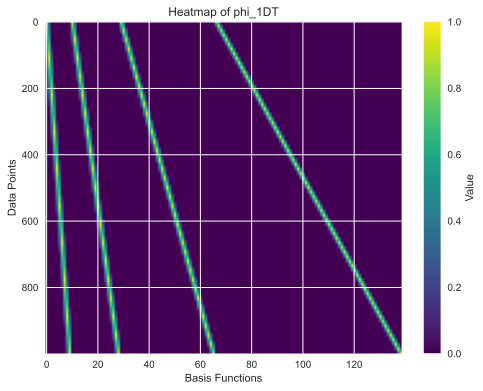

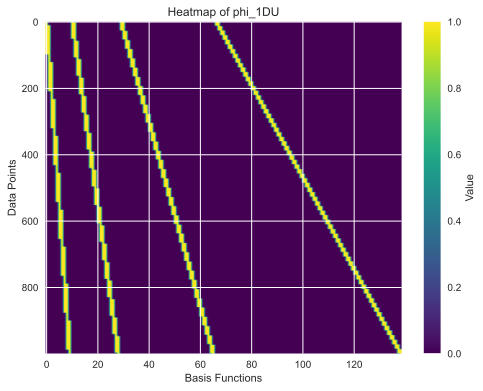

In [ ]:
# visualize the basis functions
## Wendland functions
plt.imshow(phi_1DW, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.title('Heatmap of phi_1DW')
plt.xlabel('Basis Functions')
plt.ylabel('Data Points')
plt.show()

## Gaussian functions
plt.imshow(phi_1DG, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.title('Heatmap of phi_1DG')
plt.xlabel('Basis Functions')
plt.ylabel('Data Points')
plt.show()

## Triangular functions
plt.imshow(phi_1DT, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.title('Heatmap of phi_1DT')
plt.xlabel('Basis Functions')
plt.ylabel('Data Points')
plt.show()


In [10]:
print(s.shape)
print(X.shape)
print(y.shape)
print(phi_1DW.shape)

(1000, 1)
(1000, 1)
(1000, 10)
(1000, 139)


In [11]:
from sklearn.model_selection import train_test_split
indices = np.arange(N)
## Split the training and testing sets
s_train, s_test, X_train, X_test, phi_1DW_train, phi_1DW_test \
    , phi_1DG_train, phi_1DG_test, phi_1DT_train, phi_1DT_test \
    , y_train, y_test, idx_train, idx_test \
    = train_test_split(s, X, phi_1DW, phi_1DG, phi_1DT, y, indices, test_size=0.2)
N_train = s_train.shape[0]
N_test = s_test.shape[0]

In [12]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [130]:
def temp_model(feature_dim):
    #return create_mlp_3(feature_dim)
    return create_mlp_6w(feature_dim)

In [131]:
model_1 = temp_model(feature_dim = P)
model_2 = temp_model(feature_dim = P + 1)
model_3 = temp_model(feature_dim = P + K_1D)
model_4 = temp_model(feature_dim = P + K_1D)
model_5 = temp_model(feature_dim = P + K_1D)

 c:\Users\kgy90\OneDrive\문서\GitHub\Deepkriging_self\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [ ]:
# model with only 1
# train the model
print("[INFO] training model 1...")
model_1.fit(X_train_scaled, y_train[:,0], epochs = 200, batch_size = 32, verbose = 0)

 c:\Users\kgy90\OneDrive\문서\GitHub\Deepkriging_self\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


[INFO] training model 1...


In [ ]:
# model with coordinates
Xs_train_scaled = np.hstack((X_train_scaled,s_train))
# train the model
print("[INFO] training model 2...")
model_2.fit(Xs_train_scaled, y_train[:,0], epochs = 200, batch_size = 32, verbose = 0)

[INFO] training model 2...


In [ ]:
# model 1D basis functions
## Wendland functions
XRBFW_train_scaled = np.hstack((X_train_scaled,phi_1DW_train))
# train the model
print("[INFO] training model 3...")
model_3.fit(XRBFW_train_scaled, y_train[:,0], epochs = 200, batch_size = 32, verbose = 0)

## Gaussian functions
XRBFG_train_scaled = np.hstack((X_train_scaled,phi_1DG_train))
# train the model
print("[INFO] training model 4...")
model_4.fit(XRBFG_train_scaled, y_train[:,0], epochs = 200, batch_size = 32, verbose = 0)

## Triangular functions
XRBFT_train_scaled = np.hstack((X_train_scaled,phi_1DT_train))
# train the model
print("[INFO] training model 5...")
model_5.fit(XRBFT_train_scaled, y_train[:,0], epochs = 200, batch_size = 32, verbose = 0)


[INFO] training model 3...
[INFO] training model 4...
[INFO] training model 5...


In [91]:
Xs_scaled = np.hstack((X_scaled,s))
XRBFW_scaled = np.hstack((X_scaled,phi_1DW))
XRBFG_scaled = np.hstack((X_scaled,phi_1DG))
XRBFT_scaled = np.hstack((X_scaled,phi_1DT))
y0_test_1 = model_1.predict(X_scaled)
y0_test_2 = model_2.predict(Xs_scaled)
y0_test_3 = model_3.predict(XRBFW_scaled)
y0_test_4 = model_4.predict(XRBFG_scaled)
y0_test_5 = model_5.predict(XRBFT_scaled)
print([y0_test_1.shape,y0_test_2.shape,y0_test_3.shape,y0_test_4.shape,y0_test_5.shape])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[(1000, 1), (1000, 1), (1000, 1), (1000, 1), (1000, 1)]


In [92]:
##Warning: it is important to write 0:1 in GPRegression to get the size (Ntrain,1)
m = GPy.models.GPRegression(s_train,y_train[:,0:1] - mu[idx_train], kernel, noise_var = noise_var)
mu_GP,var_GP = m.predict(s)
lo95_GP,up95_GP = m.predict_quantiles(s)
y0_gp = mu_GP + mu
print(y0_gp.shape)

(1000, 1)


In [93]:
kernel2 = GPy.kern.Matern32(1,1,1)
m2 = GPy.models.GPRegression(s_train,y_train[:,0:1] - mu[idx_train],kernel2, noise_var = noise_var)
m2.optimize()
mu_GPE,var_GPE = m2.predict(s)
lo95_GPE,up95_GPE = m2.predict_quantiles(s)
y0_gpe = mu_GPE + mu
print(y0_gpe.shape)

(1000, 1)


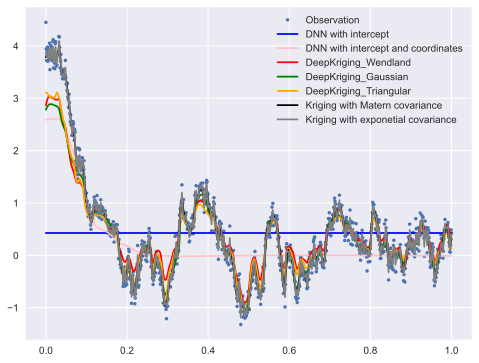

In [94]:
import pylab
pylab.plot(s, y[:,0],".",label="Observation")
pylab.plot(s, y0_test_1,'blue',label="DNN with intercept")
pylab.plot(s, y0_test_2,'pink',label="DNN with intercept and coordinates")
pylab.plot(s, y0_test_3,'red',label="DeepKriging_Wendland")
pylab.plot(s, y0_test_4,'green',label="DeepKriging_Gaussian")
pylab.plot(s, y0_test_5,'orange',label="DeepKriging_Triangular")
pylab.plot(s, y0_gpe,'black',label="Kriging with Matern covariance")
pylab.plot(s, y0_gp,'grey',label="Kriging with exponetial covariance")
pylab.legend(loc='upper right')
pylab.show()
#plt.savefig("1D_compare.pdf")

In [95]:
def rmse(y_true,y_pred):
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return float(rmse)
def mape(y_true,y_pred):
    mape = np.mean(np.absolute(y_true-y_pred)/np.absolute(y_true))
    return float(mape)

[INFO] training 1-th replicate...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
1 th replicate:
[0.06233296 0.12926452 1.03892796 0.33552846 0.12720094 0.13579627
 0.13353727]
[0.54575317 1.02781426 6.1611839  2.46387299 1.23770199 1.09367736
 0.8891998 ]
[0.15683535 0.16167359 1.00709967 0.33734675 0.1620566  0.17037418
 0.16862614]
[0.76122409 0.85878104 2.82303314 0.99124286 0.70068294 0.73228865
 0.81243712]
[INFO] training 2-th replicate..

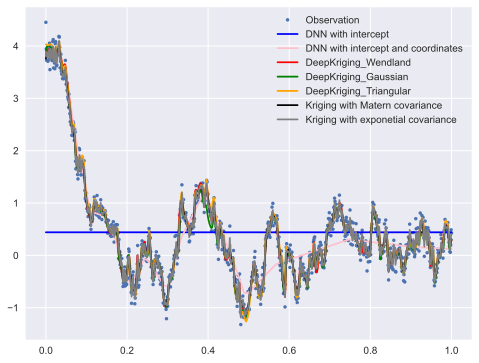

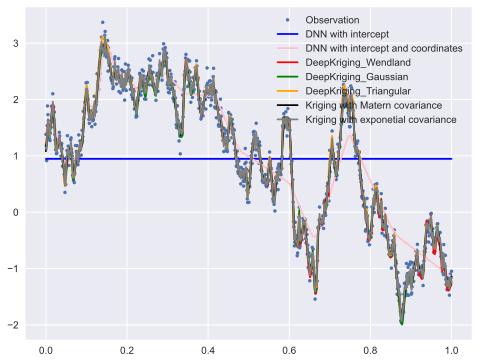

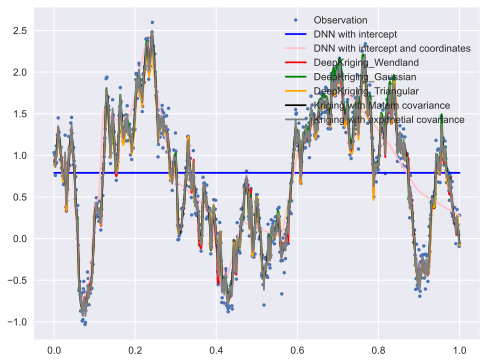

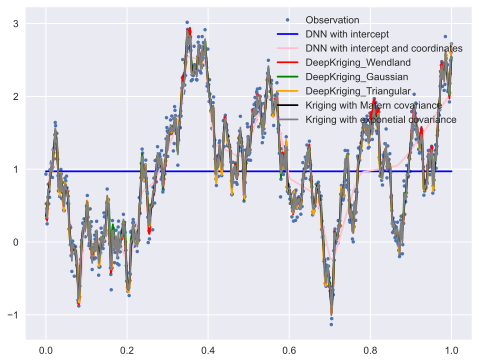

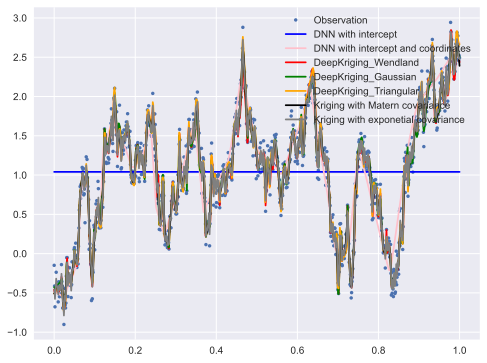

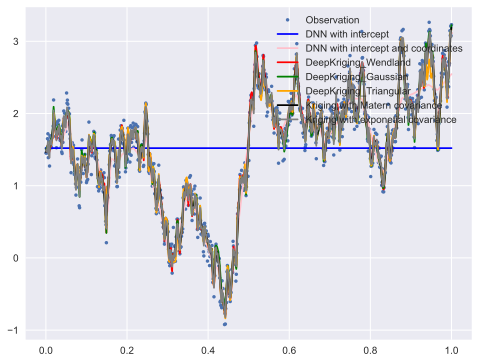

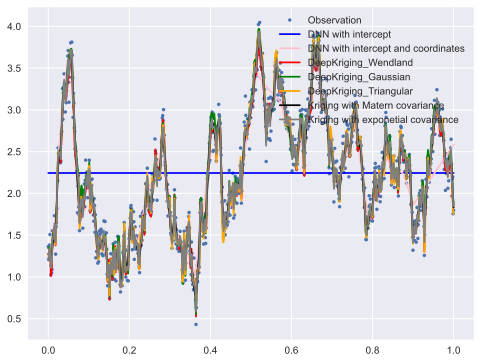

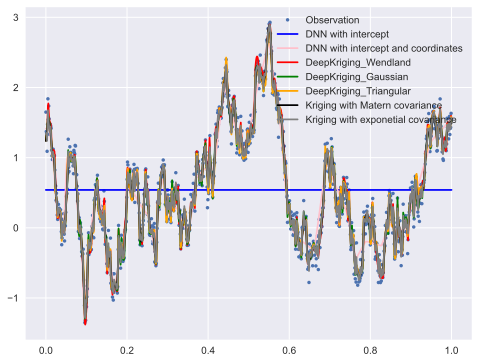

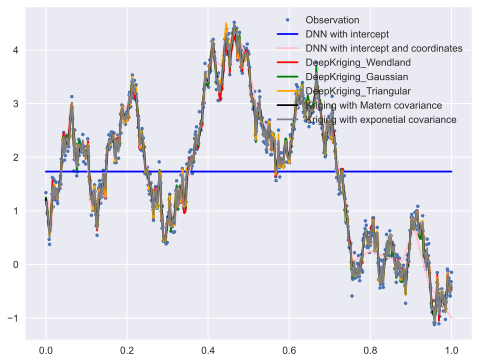

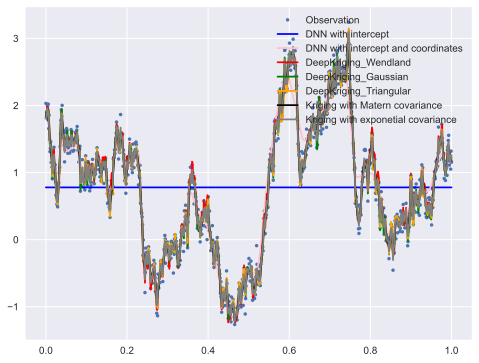

In [132]:
rmse_train_combine = np.zeros((7,M))
mape_train_combine = np.zeros((7,M))
rmse_test_combine = np.zeros((7,M))
mape_test_combine = np.zeros((7,M))

for i in range(M):
    print("[INFO] training %s-th replicate..." % (i+1))
    ##Kriging with exponential covariance
    m = GPy.models.GPRegression(s_train,y_train[:,i:(i+1)], kernel, noise_var = noise_var)
    mu_GP_train,var_GP_train = m.predict(s_train)
    y_gp_train = mu_GP_train
    mu_GP_test,var_GP_test = m.predict(s_test)
    y_gp_test = mu_GP_test
    mu_gp,var_GP = m.predict(s)
    y_gp = mu_gp

    ##Kriging with Matern covariance
    kernel2 = GPy.kern.Matern32(1,1,1)
    m2 = GPy.models.GPRegression(s_train,y_train[:,i:(i+1)],kernel2, noise_var = noise_var)
    m2.optimize()
    mu_GPE_train,var_GPE_train = m2.predict(s_train)
    y_gpe_train = mu_GPE_train
    mu_GPE_test,var_GPE_test = m2.predict(s_test)
    y_gpe_test = mu_GPE_test
    mu_GPE,var_GPE = m2.predict(s)
    y_gpe = mu_GPE
    
    epochs_size = 100 ##Number of epochs

    ##DNN with intercept
    model_1.fit(X_train_scaled, y_train[:,i], epochs = epochs_size, batch_size = 32, verbose = 0)
    y_dnn_train = model_1.predict(X_scaled[idx_train,:])
    y_dnn_test = model_1.predict(X_scaled[idx_test,:])
    y_dnn = model_1.predict(X_scaled)

    ##DNN with intercept and coordinate
    model_2.fit(Xs_train_scaled, y_train[:,i], epochs = epochs_size, batch_size = 32, verbose = 0)
    y_dnn2_train = model_2.predict(Xs_scaled[idx_train,:])
    y_dnn2_test = model_2.predict(Xs_scaled[idx_test,:])
    y_dnn2 = model_2.predict(Xs_scaled)

    ##DeepKriging with Wendland kernel
    model_3.fit(XRBFW_train_scaled, y_train[:,i], epochs = epochs_size, batch_size = 32, verbose = 0)
    y_dkw_train = model_3.predict(XRBFW_scaled[idx_train,:])
    y_dkw_test = model_3.predict(XRBFW_scaled[idx_test,:])
    y_dkw = model_3.predict(XRBFW_scaled)
    
    ##DeepKriging with Gaussian kernel
    model_4.fit(XRBFG_train_scaled, y_train[:,i], epochs = epochs_size, batch_size = 32, verbose = 0)
    y_dkg_train = model_4.predict(XRBFG_scaled[idx_train,:])
    y_dkg_test = model_4.predict(XRBFG_scaled[idx_test,:])
    y_dkg = model_4.predict(XRBFG_scaled)
    
    ##DeepKriging with Triangular kernel
    model_5.fit(XRBFT_train_scaled, y_train[:,i], epochs = epochs_size, batch_size = 32, verbose = 0)
    y_dkt_train = model_5.predict(XRBFT_scaled[idx_train,:])
    y_dkt_test = model_5.predict(XRBFT_scaled[idx_test,:])
    y_dkt = model_5.predict(XRBFT_scaled)

    ##Save the results
    rmse_train_combine[:,i] = np.array([rmse(y_train[:,i],y_gp_train[:,0]),\
                                  rmse(y_train[:,i],y_gpe_train[:,0]),\
                                  rmse(y_train[:,i],y_dnn_train[:,0]),\
                                  rmse(y_train[:,i],y_dnn2_train[:,0]),\
                                  rmse(y_train[:,i],y_dkw_train[:,0]),\
                                  rmse(y_train[:,i],y_dkg_train[:,0]),\
                                  rmse(y_train[:,i],y_dkt_train[:,0])])
    mape_train_combine[:,i] = np.array([mape(y_train[:,i],y_gp_train[:,0]),\
                                  mape(y_train[:,i],y_gpe_train[:,0]),\
                                  mape(y_train[:,i],y_dnn_train[:,0]),\
                                  mape(y_train[:,i],y_dnn2_train[:,0]),\
                                  mape(y_train[:,i],y_dkw_train[:,0]),\
                                  mape(y_train[:,i],y_dkg_train[:,0]),\
                                  mape(y_train[:,i],y_dkt_train[:,0])])
    rmse_test_combine[:,i] = np.array([rmse(y_test[:,i],y_gp_test[:,0]),\
                                  rmse(y_test[:,i],y_gpe_test[:,0]),\
                                  rmse(y_test[:,i],y_dnn_test[:,0]),\
                                  rmse(y_test[:,i],y_dnn2_test[:,0]),\
                                  rmse(y_test[:,i],y_dkw_test[:,0]),\
                                  rmse(y_test[:,i],y_dkg_test[:,0]),\
                                  rmse(y_test[:,i],y_dkt_test[:,0])])
    mape_test_combine[:,i] = np.array([mape(y_test[:,i],y_gp_test[:,0]),\
                                  mape(y_test[:,i],y_gpe_test[:,0]),\
                                  mape(y_test[:,i],y_dnn_test[:,0]),\
                                  mape(y_test[:,i],y_dnn2_test[:,0]),\
                                  mape(y_test[:,i],y_dkw_test[:,0]),\
                                  mape(y_test[:,i],y_dkg_test[:,0]),\
                                  mape(y_test[:,i],y_dkt_test[:,0])])

    print(i+1,"th replicate:")
    print(rmse_train_combine[:,i])
    print(mape_train_combine[:,i])
    print(rmse_test_combine[:,i])
    print(mape_test_combine[:,i])
    
    plt.figure()    
    pylab.plot(s, y[:,i],".",label="Observation")
    pylab.plot(s, y_dnn,'blue',label="DNN with intercept")
    pylab.plot(s, y_dnn2,'pink',label="DNN with intercept and coordinates")
    pylab.plot(s, y_dkw,'red',label="DeepKriging_Wendland")
    pylab.plot(s, y_dkg,'green',label="DeepKriging_Gaussian")
    pylab.plot(s, y_dkt,'orange',label="DeepKriging_Triangular")
    pylab.plot(s, y_gpe,'black',label="Kriging with Matern covariance")
    pylab.plot(s, y_gp,'grey',label="Kriging with exponetial covariance")
    pylab.legend(loc='upper right')
    plt.savefig("1D_compare_%sth.pdf" % (i+1))

In [135]:
print(np.mean(rmse_train_combine,axis=1))
print(np.std(rmse_train_combine,axis=1))
print(np.mean(mape_train_combine,axis=1))
print(np.std(mape_train_combine,axis=1))

[0.06266215 0.12747017 0.91974703 0.29988596 0.10956259 0.11263284
 0.10873673]
[0.00156479 0.00363509 0.19799593 0.06283557 0.00940134 0.0138215
 0.01381634]
[0.20966512 0.41256694 3.35332481 0.90833592 0.36527812 0.37949044
 0.33618611]
[0.14255748 0.26315012 1.49769213 0.63959732 0.32103806 0.30108092
 0.2351366 ]


In [136]:
print(np.mean(rmse_test_combine,axis=1))
print(np.std(rmse_test_combine,axis=1))
print(np.mean(mape_test_combine,axis=1))
print(np.std(mape_test_combine,axis=1))

[0.15682001 0.16408482 0.92260176 0.30015245 0.16765564 0.16842892
 0.16994569]
[0.00878471 0.01043482 0.19722341 0.07548233 0.00884298 0.01277417
 0.00877807]
[17.76764321 17.70538135 36.4096698   9.48006146 26.44234485 14.65758404
 18.92282198]
[ 52.16100015  51.85254495 101.9048238   26.1905235   78.17320481
  42.76165786  55.60147893]


In [137]:
result_combine = np.vstack((np.mean(rmse_train_combine,axis=1),np.std(rmse_train_combine,axis=1),\
                            np.mean(rmse_test_combine,axis=1),np.std(rmse_test_combine,axis=1),\
                            np.mean(mape_train_combine,axis=1),np.std(mape_train_combine,axis=1),\
                            np.mean(mape_test_combine,axis=1),np.std(mape_test_combine,axis=1))).T

In [138]:
import pandas as pd
# Define row and column names
col_names = ['mean_rmse_train', 'std_rmse_train', 'mean_rmse_test', 'std_rmse_test',
             'mean_mape_train', 'std_mape_train', 'mean_mape_test', 'std_mape_test']
row_names = ['Kriging_exp', 'Kriging_Matern', 'only x=1', 'base DNN', 'DK_Wendland', 'DK_Gaussian', 'DK_Triangular']

# Convert to DataFrame
df_result_combine = pd.DataFrame(result_combine, index=row_names, columns=col_names)

# Display the DataFrame
print(df_result_combine)

                mean_rmse_train  std_rmse_train  mean_rmse_test  \
Kriging_exp            0.062662        0.001565        0.156820   
Kriging_Matern         0.127470        0.003635        0.164085   
only x=1               0.919747        0.197996        0.922602   
base DNN               0.299886        0.062836        0.300152   
DK_Wendland            0.109563        0.009401        0.167656   
DK_Gaussian            0.112633        0.013821        0.168429   
DK_Triangular          0.108737        0.013816        0.169946   

                std_rmse_test  mean_mape_train  std_mape_train  \
Kriging_exp          0.008785         0.209665        0.142557   
Kriging_Matern       0.010435         0.412567        0.263150   
only x=1             0.197223         3.353325        1.497692   
base DNN             0.075482         0.908336        0.639597   
DK_Wendland          0.008843         0.365278        0.321038   
DK_Gaussian          0.012774         0.379490        0.301081   
D

In [139]:
df_result_combine.to_csv("1D_compare.csv")

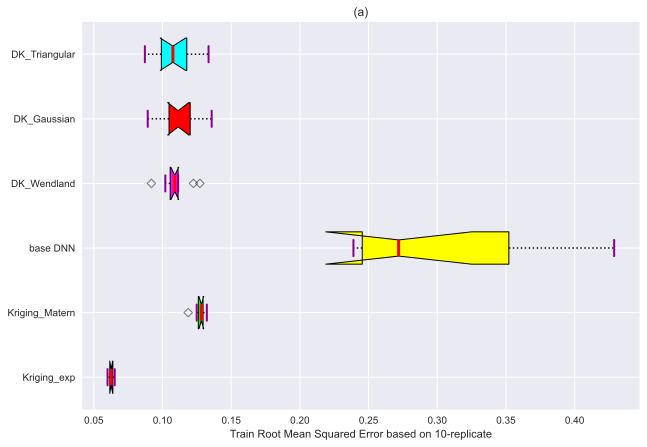

In [140]:
row_to_include = [0,1,3,4,5,6]
rmse_train_data= rmse_train_combine[row_to_include,:].T
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

# Creating axes instance
bp = ax.boxplot(rmse_train_data, patch_artist = True,
                notch ='True', vert = 0)

colors = ['#0000FF', '#00FF00', '#FFFF00','#FF00FF','#FF0000','#00FFFF']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")

# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)

# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)

# x-axis labels
ax.set_yticklabels(['Kriging_exp', 'Kriging_Matern', 'base DNN', 'DK_Wendland', 'DK_Gaussian', 'DK_Triangular'])

# Adding title
plt.title("(a)")
plt.xlabel('Train Root Mean Squared Error based on 10-replicate')
#plt.xlim((0,0.02))
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# show plot
#plt.show(bp)
plt.savefig("boxplot_1D_rmse_train.pdf")

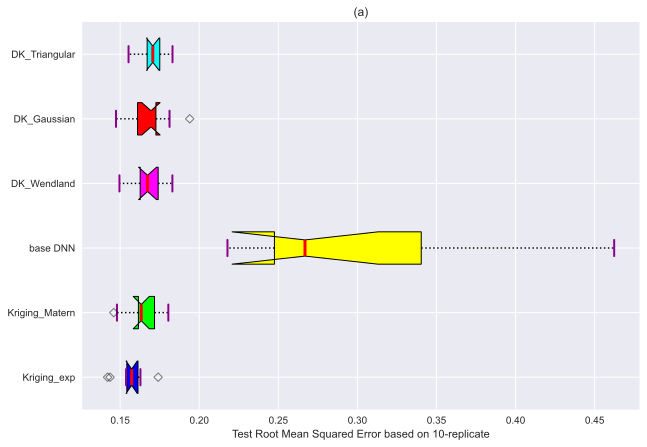

In [141]:
row_to_include = [0,1,3,4,5,6]
rmse_test_data= rmse_test_combine[row_to_include,:].T
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

# Creating axes instance
bp = ax.boxplot(rmse_test_data, patch_artist = True,
                notch ='True', vert = 0)

colors = ['#0000FF', '#00FF00', '#FFFF00','#FF00FF','#FF0000','#00FFFF']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")

# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)

# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)

# x-axis labels
ax.set_yticklabels(['Kriging_exp', 'Kriging_Matern', 'base DNN', 'DK_Wendland', 'DK_Gaussian', 'DK_Triangular'])

# Adding title
plt.title("(a)")
plt.xlabel('Test Root Mean Squared Error based on 10-replicate')
#plt.xlim((0,0.02))
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# show plot
#plt.show(bp)
plt.savefig("boxplot_1D_rmse_test.pdf")

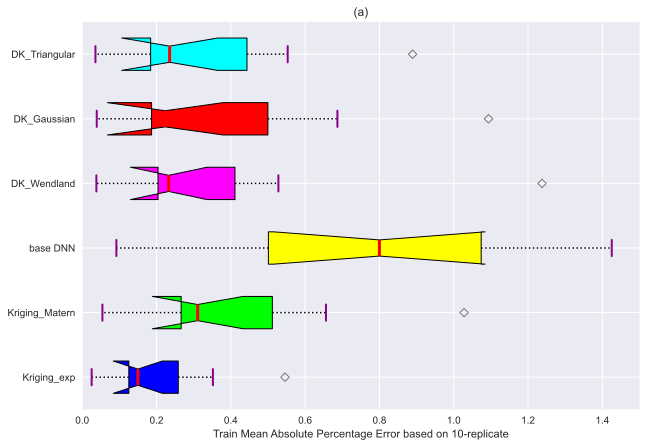

In [142]:
row_to_include = [0,1,3,4,5,6]
mape_train_data= mape_train_combine[row_to_include,:].T
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

# Creating axes instance
bp = ax.boxplot(mape_train_data, patch_artist = True,
                notch ='True', vert = 0)

colors = ['#0000FF', '#00FF00', '#FFFF00','#FF00FF','#FF0000','#00FFFF']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")

# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)

# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)

# x-axis labels
ax.set_yticklabels(['Kriging_exp', 'Kriging_Matern', 'base DNN', 'DK_Wendland', 'DK_Gaussian', 'DK_Triangular'])

# Adding title
plt.title("(a)")
plt.xlabel('Train Mean Absolute Percentage Error based on 10-replicate')
plt.xlim((0,1.5))
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# show plot
#plt.show(bp)
plt.savefig("boxplot_1D_mape_train.pdf")

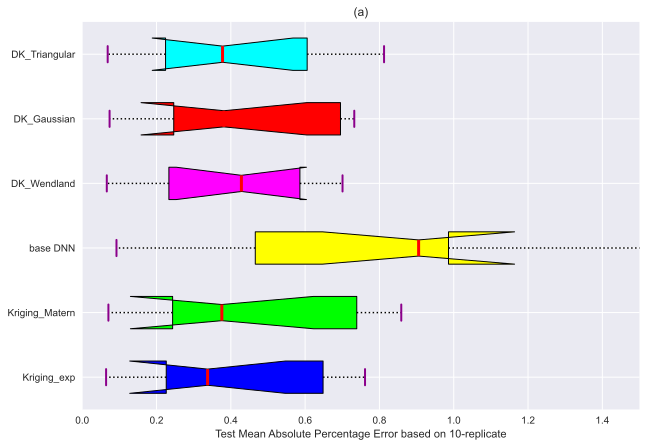

In [143]:
row_to_include = [0,1,3,4,5,6]
mape_test_data= mape_test_combine[row_to_include,:].T
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

# Creating axes instance
bp = ax.boxplot(mape_test_data, patch_artist = True,
                notch ='True', vert = 0)

colors = ['#0000FF', '#00FF00', '#FFFF00','#FF00FF','#FF0000','#00FFFF']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")

# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)

# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)

# x-axis labels
ax.set_yticklabels(['Kriging_exp', 'Kriging_Matern', 'base DNN', 'DK_Wendland', 'DK_Gaussian', 'DK_Triangular'])

# Adding title
plt.title("(a)")
plt.xlabel('Test Mean Absolute Percentage Error based on 10-replicate')
plt.xlim((0,1.5))
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# show plot
#plt.show(bp)
plt.savefig("boxplot_1D_mape_test.pdf")